In [1]:
import custom_functions as fn
import tensorflow as tf
import numpy as np
# Then Set Random Seeds
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)
# Then run the Enable Deterministic Operations Function
tf.config.experimental.enable_op_determinism()

In [2]:
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_colwidth', 250)

In [3]:
# Load Data from your path
df = pd.read_csv("Data/yelp-reviews-CA-2015-2018.csv.gz", index_col = 'date', parse_dates=['date'])
## Remove any non-english reviews
df = df.loc[ df['language']=='en'].copy()
# Keep only 1,3,5 star reviews
df = df.loc[ df['stars'].isin([1,3,5])]
# Take a smaller subset
df = df.loc['2018']
# Set the index
df = df.set_index('review_id')
# We will split on each space, and then get the length
df['sequence_length'] =df['text'].map( lambda x: len(x.split(" ")))
# Define a filter to identify reviews less than 400 words
filter_short = df['sequence_length']< 400
# Keep short reviews (<400 words)
df=  df.loc[filter_short]
# Use RUS to reduce n to match minority group
sampler = RandomUnderSampler(random_state=42)
df_ml,  _ = sampler.fit_resample(df, df['stars'])
df_ml['stars'].value_counts()
# Define X
X = df_ml['text'].values
# Create a map for targets
target_map = {1:0,
              3:1,
              5:2}
# Define y and apply the target_map
y = df_ml['stars'].map(target_map)
# Define classes variable
classes = y.unique()
classes


array([0, 1, 2], dtype=int64)

In [4]:
# Convert to Dataset Object
ds = tf.data.Dataset.from_tensor_slices((X, y))
# Shuffle dataset
ds = ds.shuffle(buffer_size=len(ds),reshuffle_each_iteration=False)

In [5]:
# Set the ratio of the train, validation, test split
split_train = .7
split_val =  .2
split_test =  1 -( split_train + split_val )
# Calculate the number of samples for training and validation data 
n_train_samples =  int(len(ds) * split_train)
n_val_samples = int(len(ds) * split_val)
n_test_samples = len(ds) -(n_train_samples + n_val_samples)
# Set the batch size
BATCH_SIZE =32
import math
# math.ceil will round up
# How many batches? 
n_train_batches = math.ceil(n_train_samples/BATCH_SIZE)
n_val_batches = math.ceil(n_val_samples/BATCH_SIZE)
n_test_batches = math.ceil(n_test_samples/BATCH_SIZE)
print(f"    - train:\t{n_train_samples} samples \t({n_train_batches} batches)")
print(f"    - val:  \t{n_val_samples} samples \t({n_val_batches} batches)")
print(f"    - test: \t{n_test_samples} samples \t({n_test_batches} batches)")

    - train:	5178 samples 	(162 batches)
    - val:  	1479 samples 	(47 batches)
    - test: 	741 samples 	(24 batches)


In [6]:
# Use take and skip to define each set
train_ds = ds.take(n_train_samples).batch(batch_size=BATCH_SIZE)
# Skip over the training batches and take the validation batches
val_ds = ds.skip(n_train_samples).take(n_val_samples).batch(batch_size=BATCH_SIZE)
# Skipver the train and validation batches, the remaining are the test batches
test_ds = ds.skip(n_train_samples + n_val_samples).batch(batch_size=BATCH_SIZE)

In [7]:
# Confirm the number of batches in each
print (f' There are {len(train_ds)} training batches.')
print (f' There are {len(val_ds)} validation batches.')
print (f' There are {len(test_ds)} testing batches.')

 There are 162 training batches.
 There are 47 validation batches.
 There are 24 testing batches.


In [8]:
from pprint import pprint
def make_text_vectorization_layer(train_ds,  max_tokens=None, 
                                  split='whitespace',
                                  standardize="lower_and_strip_punctuation",
                                  output_mode="int",
                                  output_sequence_length=None,
                                  ngrams=None, pad_to_max_tokens=False,
                                  verbose=True,
                                  **kwargs,
                                 ):
    # Build the text vectorization layer
    text_vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=max_tokens,
        standardize=standardize, 
        output_mode=output_mode,
        output_sequence_length=output_sequence_length,
        **kwargs
    )
    # Get just the text from the training data
    if isinstance(train_ds, (np.ndarray, list, tuple, pd.Series)):
        ds_texts = train_ds
    else:
        try:
            ds_texts = train_ds.map(lambda x, y: x )
        except:
            ds_texts = train_ds
            
    # Fit the layer on the training texts
    text_vectorizer.adapt(ds_texts)
    
    
    if verbose:
        # Print the params
        print( "\ntf.keras.layers.TextVectorization(" )
        config = text_vectorizer.get_config()
        pprint(config,indent=4)
        print(")")
               
    # SAVING VOCAB FOR LATER
    # Getting list of vocab 
    vocab = text_vectorizer.get_vocabulary()
    # Save dictionaries to look up words from ints 
    int_to_str  = {idx:word for idx, word in enumerate(vocab)}
    
    return text_vectorizer, int_to_str

In [9]:
# Define sequence length as a variable for future use
SEQUENCE_LENGTH = 400
# Define vectorizer layer. Use the custom function to build and fit the vectorizer before using it in model
sequence_vectorizer, vocab_lookup = make_text_vectorization_layer(train_ds, output_mode='int', output_sequence_length = SEQUENCE_LENGTH, verbose=True)


tf.keras.layers.TextVectorization(
{   'batch_input_shape': (None,),
    'dtype': 'string',
    'encoding': 'utf-8',
    'idf_weights': None,
    'max_tokens': None,
    'name': 'text_vectorization',
    'ngrams': None,
    'output_mode': 'int',
    'output_sequence_length': 400,
    'pad_to_max_tokens': False,
    'ragged': False,
    'sparse': False,
    'split': 'whitespace',
    'standardize': 'lower_and_strip_punctuation',
    'trainable': True,
    'vocabulary': None,
    'vocabulary_size': 18516}
)


In [10]:
# Check the size of the vocabulary
VOCAB_SIZE = len(sequence_vectorizer.get_vocabulary())
VOCAB_SIZE

18516

In [11]:
# Get the size of the vocabulary
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()
VOCAB_SIZE

18516

In [12]:
# Define output dimension
EMBED_DIM = 100
EMBED_DIM

100

In [13]:
# Define a function for building an LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, regularizers
def build_lstm_model(text_vectorization_layer):
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    lstm_model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    # Add *new* LSTM layer
    lstm_model.add(layers.LSTM(128))
    # Add output layer
    lstm_model.add(layers.Dense(len(classes), activation='softmax'))
 
    # Compile the model
    lstm_model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .01), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    lstm_model.summary()
    return lstm_model

In [14]:
# Include callbacks
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 400)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 400, 100)          1851600   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 1,969,235
Trainable params: 1,969,235
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
162/162 [==============================] - 80s 462ms/step - loss: 1.1326 - accuracy: 0.3258 - val_los

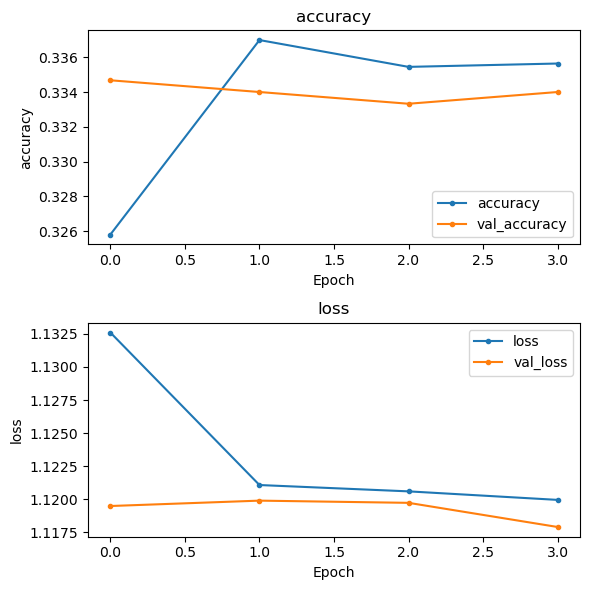


- Evaluating Network...


C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.34      0.44      0.38      1721
           1       0.34      0.57      0.43      1732
           2       0.00      0.00      0.00      1725

    accuracy                           0.34      5178
   macro avg       0.23      0.34      0.27      5178
weighted avg       0.23      0.34      0.27      5178



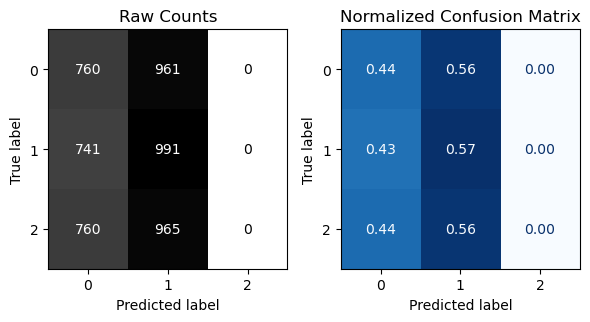


- Evaluating Training Data:
  2/162 [..............................] - ETA: 12s - loss: 1.1018 - accuracy: 0.4062

C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


162/162 [==============================] - 12s 73ms/step - loss: 1.1209 - accuracy: 0.3382
{'loss': 1.1209355592727661, 'accuracy': 0.338161438703537}


C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.33      0.41      0.36       253
           1       0.35      0.59      0.44       254
           2       0.00      0.00      0.00       234

    accuracy                           0.34       741
   macro avg       0.23      0.33      0.27       741
weighted avg       0.23      0.34      0.28       741



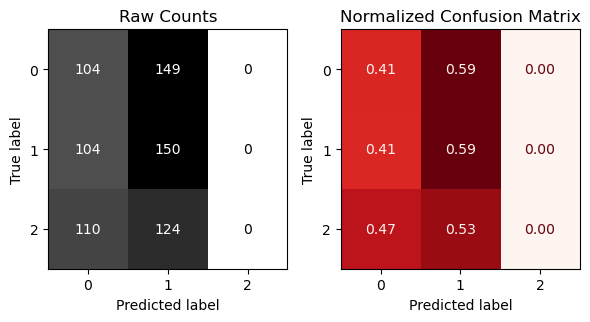


- Evaluating Test Data:
 2/24 [=>............................] - ETA: 1s - loss: 1.1195 - accuracy: 0.3281

C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


24/24 [==============================] - 2s 73ms/step - loss: 1.1165 - accuracy: 0.3428
{'loss': 1.1165112257003784, 'accuracy': 0.3427800238132477}


In [15]:
# Build the lstm model and specify the vectorizer
lstm_model = build_lstm_model(sequence_vectorizer)
# Defien number of epocs
EPOCHS = 30
# Fit the model
history = lstm_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)
# Obtain the results
results = fn.evaluate_classification_network(
    lstm_model, X_train=train_ds, 
    X_test=test_ds, history=history
);

# GRUs

In [16]:
# Confirm these values
print(f' VOCAB_SIZE: {VOCAB_SIZE}')
print(f' EMBED_DIM: {EMBED_DIM}')
print(f' SEQUENCE_LENGTH: {SEQUENCE_LENGTH}')

 VOCAB_SIZE: 18516
 EMBED_DIM: 100
 SEQUENCE_LENGTH: 400


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, regularizers
def build_gru_model(text_vectorization_layer):
                
    gru_model = Sequential([
        text_vectorization_layer,
        tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)])
    # Add GRU layer *new*
    gru_model.add(layers.GRU(128, return_sequences = True))   
    gru_model.add(layers.GlobalMaxPooling1D())
    # Output layer
    gru_model.add(layers.Dense(len(classes), 
                              activation='softmax'))
        
    optimizer = optimizers.legacy.Adam()
    gru_model.compile(optimizer=optimizer,  
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    gru_model.summary()
    return gru_model

In [18]:
# Include callbacks
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 400)              0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 400, 100)          1851600   
                                                                 
 gru (GRU)                   (None, 400, 128)          88320     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1,940,307
Trainable params: 1,940,307
No

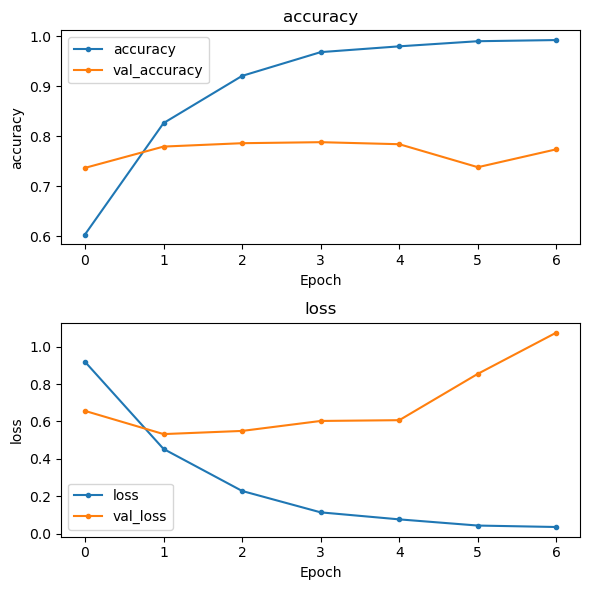


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      1721
           1       0.97      1.00      0.99      1732
           2       1.00      1.00      1.00      1725

    accuracy                           0.99      5178
   macro avg       0.99      0.99      0.99      5178
weighted avg       0.99      0.99      0.99      5178



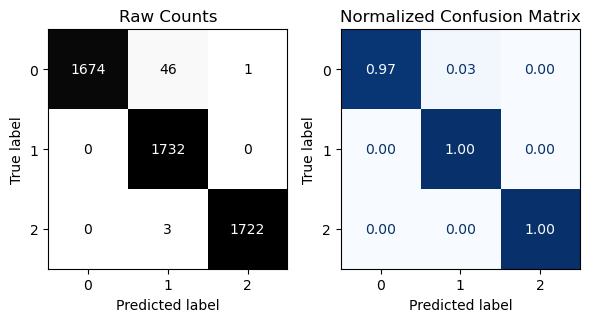


- Evaluating Training Data:
162/162 [==============================] - 10s 61ms/step - loss: 0.0382 - accuracy: 0.9903
{'loss': 0.03817376866936684, 'accuracy': 0.9903437495231628}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.66      0.72       253
           1       0.61      0.81      0.70       254
           2       0.89      0.76      0.82       234

    accuracy                           0.74       741
   macro avg       0.77      0.74      0.75       741
weighted avg       0.77      0.74      0.75       741



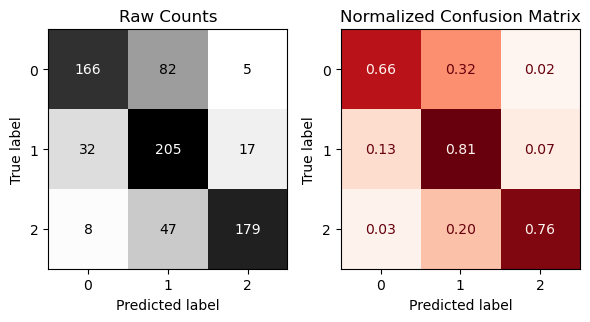


- Evaluating Test Data:
24/24 [==============================] - 1s 58ms/step - loss: 1.2168 - accuracy: 0.7422
{'loss': 1.2168290615081787, 'accuracy': 0.7422401905059814}


In [19]:
# Build the model
model = build_gru_model(sequence_vectorizer)
# Fit the model
EPOCHS = 30
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)
# Evaluate the model
results = fn.evaluate_classification_network(
    model, X_train=train_ds,
    X_test=test_ds, history=history);

# Stacked RNNs

## GRU stacked

In [20]:
def build_gru_model_stack_deep_pool(text_vectorization_layer):
    
    
    MAX_TOKENS = text_vectorization_layer.vocabulary_size()
        
    model = tf.keras.Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)])

    # Stack three GrU layers    
    model.add(layers.GRU(128, return_sequences=True))
    model.add(layers.Dropout(.5))
    model.add(layers.GRU(128, return_sequences=True))
    model.add(layers.Dropout(.5))         
    # For the final GRU layer, use return_sequences = True for pooling layer
    model.add(layers.GRU(128, return_sequences = True)) 
    model.add(layers.GlobalMaxPooling1D())
    # Output layer
    model.add(layers.Dense(len(classes), 
                              activation='softmax'))

              
    # Define optimizer
    optimizer = optimizers.legacy.Adam()

    # Compile
    model.compile(optimizer=optimizer,  
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [21]:
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 400)              0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, 400, 100)          1851600   
                                                                 
 gru_1 (GRU)                 (None, 400, 128)          88320     
                                                                 
 dropout (Dropout)           (None, 400, 128)          0         
                                                                 
 gru_2 (GRU)                 (None, 400, 128)          99072     
                                                                 
 dropout_1 (Dropout)         (None, 400, 128)          0         
                                                      

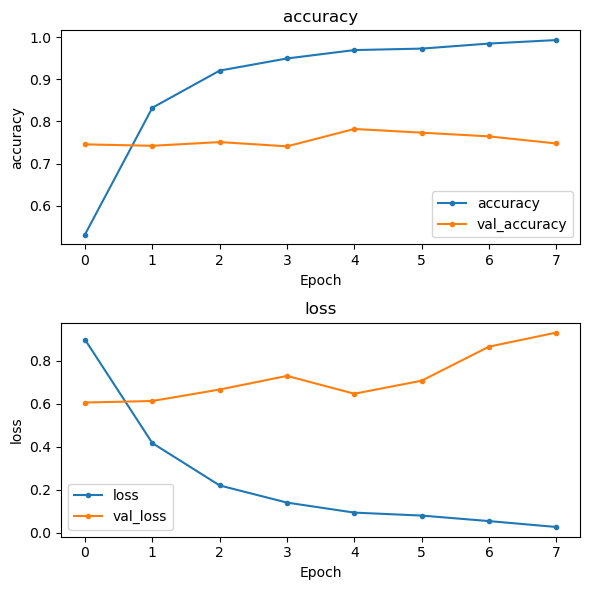


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.64      0.71       253
           1       0.57      0.79      0.67       254
           2       0.86      0.69      0.76       234

    accuracy                           0.71       741
   macro avg       0.74      0.71      0.71       741
weighted avg       0.74      0.71      0.71       741



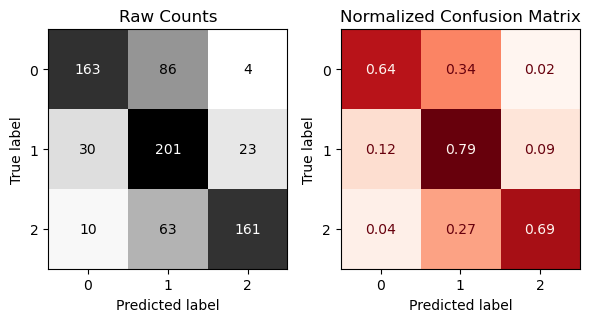


- Evaluating Test Data:
24/24 [==============================] - 4s 183ms/step - loss: 1.0522 - accuracy: 0.7085
{'loss': 1.052215337753296, 'accuracy': 0.7085019946098328}


In [22]:
# Build model
model = build_gru_model_stack_deep_pool(sequence_vectorizer)

EPOCHS = 30
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)
results = fn.evaluate_classification_network(
    model,
    X_test=test_ds, history=history
);

## Stacked RNN

In [23]:
def build_gru_model_stack_hierarchy_pool(text_vectorization_layer):
    
    
    MAX_TOKENS = text_vectorization_layer.vocabulary_size()
        
    model = tf.keras.Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)])

    # Stack three GrU layers    
    model.add(layers.GRU(128, return_sequences=True))
    model.add(layers.Dropout(.5))
    model.add(layers.GRU(64, return_sequences=True))
    model.add(layers.Dropout(.5))         
    # For the final GRU layer, use return_sequences = True for pooling layer
    model.add(layers.GRU(32, return_sequences = True)) 
    model.add(layers.GlobalMaxPooling1D())
    # Output layer
    model.add(layers.Dense(len(classes), 
                              activation='softmax'))

              
    # Define optimizer
    optimizer = optimizers.legacy.Adam()

    # Compile
    model.compile(optimizer=optimizer,  
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 400)              0         
 torization)                                                     
                                                                 
 embedding_3 (Embedding)     (None, 400, 100)          1851600   
                                                                 
 gru_4 (GRU)                 (None, 400, 128)          88320     
                                                                 
 dropout_2 (Dropout)         (None, 400, 128)          0         
                                                                 
 gru_5 (GRU)                 (None, 400, 64)           37248     
                                                                 
 dropout_3 (Dropout)         (None, 400, 64)           0         
                                                      

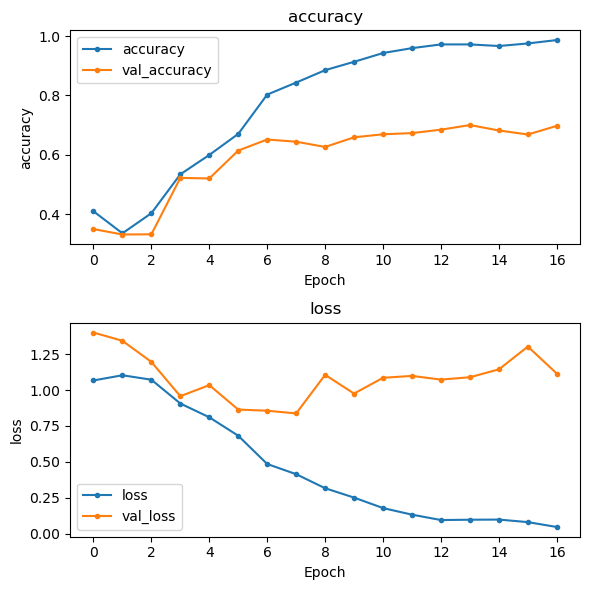


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.78      0.74       253
           1       0.55      0.62      0.58       254
           2       0.83      0.64      0.72       234

    accuracy                           0.68       741
   macro avg       0.70      0.68      0.68       741
weighted avg       0.69      0.68      0.68       741



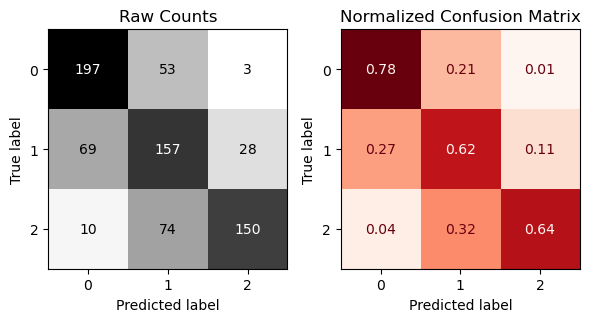


- Evaluating Test Data:
24/24 [==============================] - 3s 108ms/step - loss: 1.2302 - accuracy: 0.6802
{'loss': 1.2301770448684692, 'accuracy': 0.6801619529724121}


In [24]:
# Build model
model = build_gru_model_stack_hierarchy_pool(sequence_vectorizer)

EPOCHS = 30
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)
results = fn.evaluate_classification_network(
    model, 
    X_test=test_ds, history=history
);

## Hybrid Stacked RNN

In [25]:
def build_hybrid_model_deep_pool(text_vectorization_layer):
    
    
    MAX_TOKENS = text_vectorization_layer.vocabulary_size()
        
    model = tf.keras.Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)])

    # Stack   
    model.add(layers.GRU(128, return_sequences=True))
    model.add(layers.Dropout(.5))     
    # For the final layer, use return_sequences = True for pooling layer
    model.add(layers.LSTM(128, return_sequences = True)) 
    model.add(layers.GlobalMaxPooling1D())
    # Output layer
    model.add(layers.Dense(len(classes), 
                              activation='softmax'))

              
    # Define optimizer
    optimizer = optimizers.legacy.Adam()

    # Compile
    model.compile(optimizer=optimizer,  
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 400)              0         
 torization)                                                     
                                                                 
 embedding_4 (Embedding)     (None, 400, 100)          1851600   
                                                                 
 gru_7 (GRU)                 (None, 400, 128)          88320     
                                                                 
 dropout_4 (Dropout)         (None, 400, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 400, 128)          131584    
                                                                 
 global_max_pooling1d_3 (Glo  (None, 128)              0         
 balMaxPooling1D)                                     

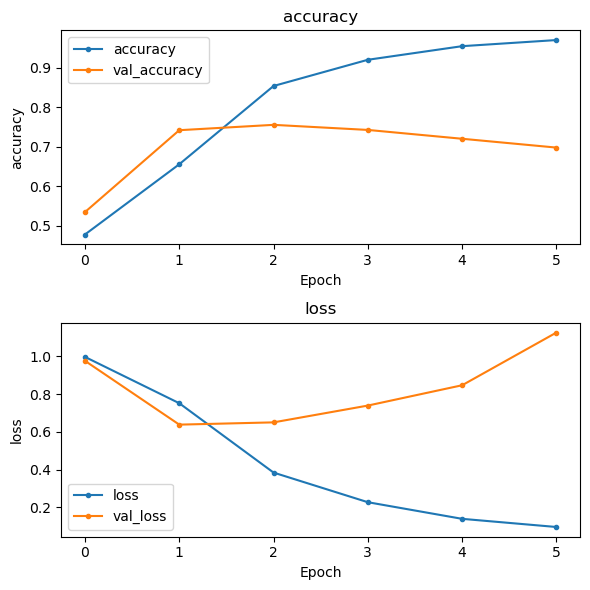


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.61      0.92      0.74       253
           1       0.73      0.31      0.43       254
           2       0.73      0.80      0.77       234

    accuracy                           0.67       741
   macro avg       0.69      0.68      0.64       741
weighted avg       0.69      0.67      0.64       741



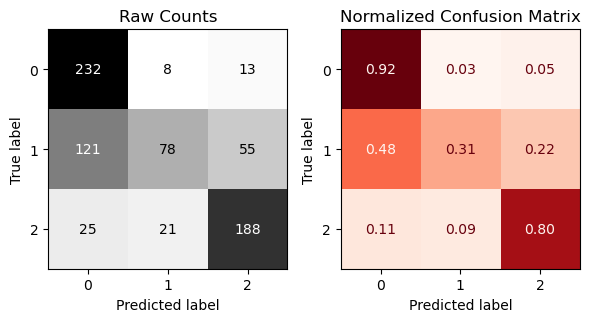


- Evaluating Test Data:
24/24 [==============================] - 4s 158ms/step - loss: 1.2193 - accuracy: 0.6721
{'loss': 1.2193324565887451, 'accuracy': 0.6720647811889648}


In [26]:
# Build model
model = build_hybrid_model_deep_pool(sequence_vectorizer)

EPOCHS = 30
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)
results = fn.evaluate_classification_network(
    model, 
    X_test=test_ds, history=history
);

# Bi-Directional RNNs

In [27]:
# Confirm these values
print(f' VOCAB_SIZE: {VOCAB_SIZE}')
print(f' EMBED_DIM: {EMBED_DIM}')
print(f' SEQUENCE_LENGTH: {SEQUENCE_LENGTH}')

 VOCAB_SIZE: 18516
 EMBED_DIM: 100
 SEQUENCE_LENGTH: 400


In [28]:
def build_gru_model_bi_pool(text_vectorization_layer):
    
    gru_model_bi_pool = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                      output_dim=EMBED_DIM,
                      input_length=SEQUENCE_LENGTH)])
        
    # Add bidirectional component to GRU layer 
    gru_model_bi_pool.add(layers.Bidirectional(layers.GRU(128, return_sequences = True)))
    
    # Add a pooling layer *new
    gru_model_bi_pool.add(layers.GlobalMaxPooling1D())
    
    # Output layer
    gru_model_bi_pool.add(layers.Dense(len(classes), activation='softmax'))
                     
    optimizer = optimizers.legacy.Adam()
    gru_model_bi_pool.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    gru_model_bi_pool.summary()
    return gru_model_bi_pool

In [29]:
# Include callbacks
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 400)              0         
 torization)                                                     
                                                                 
 embedding_5 (Embedding)     (None, 400, 100)          1851600   
                                                                 
 bidirectional (Bidirectiona  (None, 400, 256)         176640    
 l)                                                              
                                                                 
 global_max_pooling1d_4 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_5 (Dense)             (None, 3)                 771       
                                                      

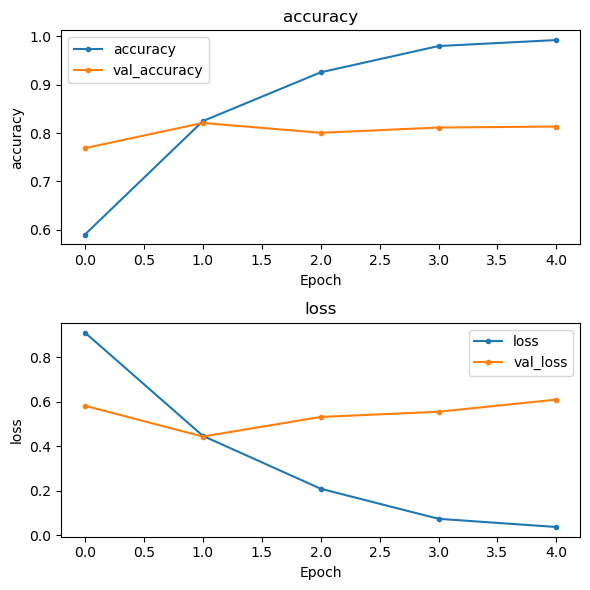


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1721
           1       1.00      1.00      1.00      1732
           2       1.00      1.00      1.00      1725

    accuracy                           1.00      5178
   macro avg       1.00      1.00      1.00      5178
weighted avg       1.00      1.00      1.00      5178



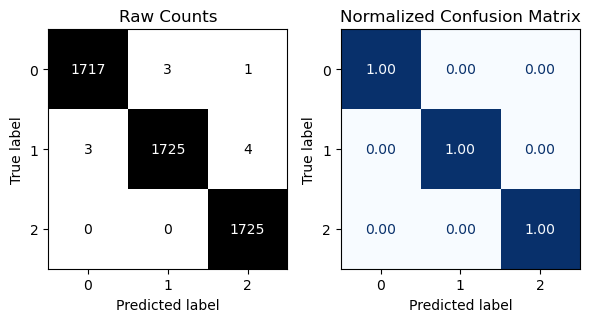


- Evaluating Training Data:
162/162 [==============================] - 16s 97ms/step - loss: 0.0121 - accuracy: 0.9979
{'loss': 0.012089884839951992, 'accuracy': 0.9978756308555603}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       253
           1       0.73      0.68      0.70       254
           2       0.85      0.86      0.85       234

    accuracy                           0.78       741
   macro avg       0.78      0.79      0.78       741
weighted avg       0.78      0.78      0.78       741



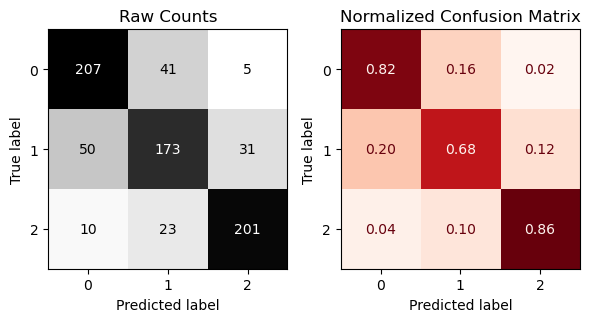


- Evaluating Test Data:
24/24 [==============================] - 2s 87ms/step - loss: 0.7668 - accuracy: 0.7841
{'loss': 0.7667754292488098, 'accuracy': 0.7840755581855774}


In [30]:
# Build the model
model = build_gru_model_bi_pool(sequence_vectorizer)

# Fit the model
EPOCHS = 30
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)

# Evaluate the model
results = fn.evaluate_classification_network(
    model, X_train=train_ds, 
    X_test=test_ds, history=history);

# Pre-Trained Word Embeddings

In [31]:
from gensim.models import KeyedVectors
# Load GloVe vectors into a gensim model
glove_model = KeyedVectors.load_word2vec_format("GloVe/glove.6B.100d.txt", binary=False, no_header=True)

In [32]:
# You can now use `glove_model` to access individual word vectors, similar to a dictionary
vector = glove_model['king']
vector

array([-0.32307 , -0.87616 ,  0.21977 ,  0.25268 ,  0.22976 ,  0.7388  ,
       -0.37954 , -0.35307 , -0.84369 , -1.1113  , -0.30266 ,  0.33178 ,
       -0.25113 ,  0.30448 , -0.077491, -0.89815 ,  0.092496, -1.1407  ,
       -0.58324 ,  0.66869 , -0.23122 , -0.95855 ,  0.28262 , -0.078848,
        0.75315 ,  0.26584 ,  0.3422  , -0.33949 ,  0.95608 ,  0.065641,
        0.45747 ,  0.39835 ,  0.57965 ,  0.39267 , -0.21851 ,  0.58795 ,
       -0.55999 ,  0.63368 , -0.043983, -0.68731 , -0.37841 ,  0.38026 ,
        0.61641 , -0.88269 , -0.12346 , -0.37928 , -0.38318 ,  0.23868 ,
        0.6685  , -0.43321 , -0.11065 ,  0.081723,  1.1569  ,  0.78958 ,
       -0.21223 , -2.3211  , -0.67806 ,  0.44561 ,  0.65707 ,  0.1045  ,
        0.46217 ,  0.19912 ,  0.25802 ,  0.057194,  0.53443 , -0.43133 ,
       -0.34311 ,  0.59789 , -0.58417 ,  0.068995,  0.23944 , -0.85181 ,
        0.30379 , -0.34177 , -0.25746 , -0.031101, -0.16285 ,  0.45169 ,
       -0.91627 ,  0.64521 ,  0.73281 , -0.22752 , 

In [33]:
# Find vector shape for given word
vector.shape

(100,)

In [34]:
# Find similarity between words
glove_model.similarity('king', 'queen')

0.7507691

In [35]:
# Find similar words
glove_model.most_similar('data', topn=10)

[('information', 0.7920401096343994),
 ('analysis', 0.7564454674720764),
 ('tracking', 0.7226751446723938),
 ('database', 0.7215273976325989),
 ('system', 0.6736716032028198),
 ('computer', 0.6733997464179993),
 ('statistics', 0.6705881953239441),
 ('systems', 0.6695857048034668),
 ('applications', 0.6660565733909607),
 ('numbers', 0.6655444502830505)]

In [36]:
# Perform word math
result = glove_model.most_similar(positive=['woman', 'king'], negative=['man'], topn=3)
result

[('queen', 0.7698541283607483),
 ('monarch', 0.6843380928039551),
 ('throne', 0.6755736470222473)]

In [37]:
# How many words are included?
len(glove_model)

400000

In [38]:
# You can now use `glove_model` to access individual word vectors, similar to a dictionary
# vector = glove_model['Sarah']
# vector

# Looking up word not in model will be a key error

## Making embedding layer

In [39]:
vocab_size = len(sequence_vectorizer.get_vocabulary())  
embedding_dim = 100  # This GloVe model contains vectors of size 100

In [40]:
# Initialize an empty matrix to hold the word embeddings
embedding_matrix = np.zeros((vocab_size, embedding_dim))

In [41]:
# Loop to get each word from vocabulary and get its pre-trained vector from GloVe model
for i, word in enumerate(sequence_vectorizer.get_vocabulary()):
    try:
        embedding_matrix[i] = glove_model[word]
    except KeyError:
        # If the word is not in the GloVe vocabulary, skip it
        pass

In [42]:
embedding_matrix[3]

array([-0.071953  ,  0.23127   ,  0.023731  , -0.50638002,  0.33923   ,
        0.19589999, -0.32943001,  0.18364   , -0.18057001,  0.28963   ,
        0.20448001, -0.54960001,  0.27399001,  0.58327001,  0.20468   ,
       -0.49228001,  0.19973999, -0.070237  , -0.88049001,  0.29484999,
        0.14071   , -0.1009    ,  0.99449003,  0.36973   ,  0.44554001,
        0.28997999, -0.1376    , -0.56365001, -0.029365  , -0.4122    ,
       -0.25268999,  0.63181001, -0.44767001,  0.24363001, -0.10813   ,
        0.25163999,  0.46967   ,  0.37549999, -0.23613   , -0.14128999,
       -0.44536999, -0.65736997, -0.042421  , -0.28636   , -0.28810999,
        0.063766  ,  0.20281   , -0.53542   ,  0.41306999, -0.59722   ,
       -0.38613999,  0.19389001, -0.17809001,  1.66180003, -0.011819  ,
       -2.3736999 ,  0.058427  , -0.26980001,  1.2823    ,  0.81924999,
       -0.22322001,  0.72931999, -0.053211  ,  0.43507001,  0.85010999,
       -0.42934999,  0.92663997,  0.39050999,  1.05850005, -0.24

In [43]:
from tensorflow.keras.layers import Embedding
# Create the embedding layer using the embedding matrix
initializer = tf.keras.initializers.Constant(embedding_matrix)
glove_embedding_layer = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            embeddings_initializer=initializer,
                            trainable=False,  # Keeps the embeddings fixed
                            input_length=SEQUENCE_LENGTH)

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, regularizers
def build_model_glove(text_vectorization_layer, glove_embedding_layer):
    
    MAX_TOKENS = text_vectorization_layer.vocabulary_size()
        
    model = Sequential([
        text_vectorization_layer,
        glove_embedding_layer])
        
    # Bidirectional GRU layer
    model.add(layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True, dropout=0.2)))
    # Pooling layer
    model.add(layers.GlobalMaxPooling1D())
    
    # Output layer
    model.add(layers.Dense(len(classes), activation='softmax'))
    # Define the optimizer
    optimizer = optimizers.legacy.Adam(learning_rate=0.01)
    # Compile the model
    model.compile(optimizer=optimizer,  
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [45]:
# using restore_best_weights = False 
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor, restore_best_weights=False)
    return [early_stop]

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 400)              0         
 torization)                                                     
                                                                 
 embedding_6 (Embedding)     (None, 400, 100)          1851600   
                                                                 
 bidirectional_1 (Bidirectio  (None, 400, 256)         176640    
 nal)                                                            
                                                                 
 global_max_pooling1d_5 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 3)                 771       
                                                      

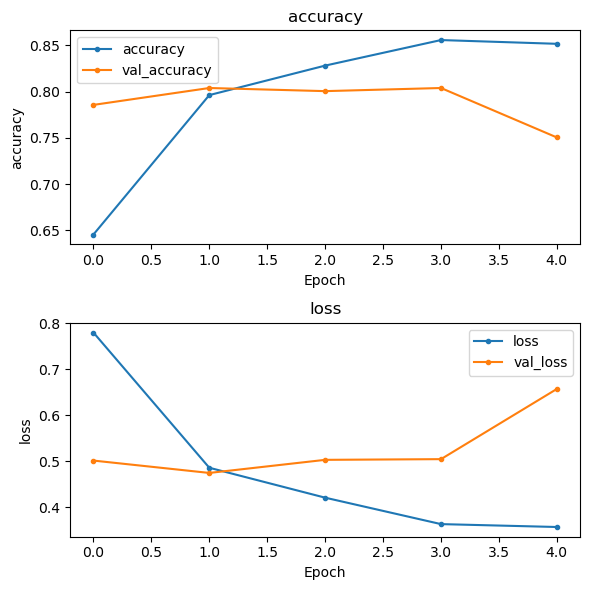


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.72      0.83      1721
           1       0.79      0.88      0.83      1732
           2       0.86      0.99      0.92      1725

    accuracy                           0.86      5178
   macro avg       0.88      0.86      0.86      5178
weighted avg       0.88      0.86      0.86      5178



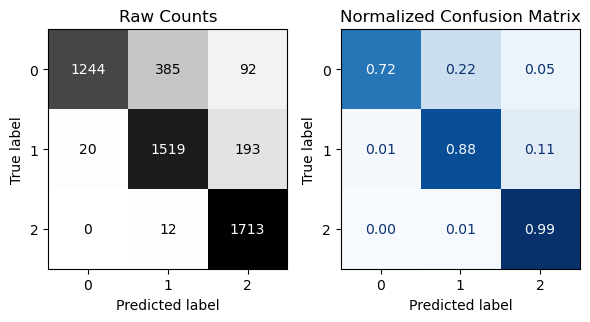


- Evaluating Training Data:
162/162 [==============================] - 15s 95ms/step - loss: 0.3318 - accuracy: 0.8644
{'loss': 0.33176833391189575, 'accuracy': 0.8644264340400696}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.62      0.73       253
           1       0.64      0.70      0.67       254
           2       0.74      0.91      0.81       234

    accuracy                           0.74       741
   macro avg       0.76      0.74      0.74       741
weighted avg       0.76      0.74      0.74       741



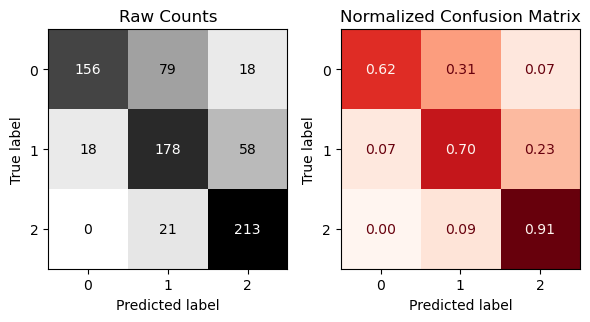


- Evaluating Test Data:
24/24 [==============================] - 2s 100ms/step - loss: 0.7274 - accuracy: 0.7382
{'loss': 0.7273712754249573, 'accuracy': 0.7381916046142578}


In [46]:
# Build the model
baseline_model = build_model_glove(sequence_vectorizer,glove_embedding_layer)
EPOCHS = 100
# Fit the mdoel
history = baseline_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)
# Evaluate the mdoel
results = fn.evaluate_classification_network(
    baseline_model, X_train=train_ds, 
    X_test=test_ds, history=history,
);

# GloVe Practice: 300d.text

In [47]:
# Load GloVe vectors into a gensim model
glove_model = KeyedVectors.load_word2vec_format("GloVe/glove.6B.300d.txt", binary=False, no_header=True)

In [48]:
# How many words are in the file?
len(glove_model)

400000

In [49]:
# Output vector of the word 'explore'
vector = glove_model['explore']
vector

array([-3.7632e-01, -8.3171e-02, -5.4273e-01, -1.8057e-01,  1.0441e-01,
        2.5691e-02, -2.3151e-01, -5.2861e-01,  3.4421e-01, -1.2153e+00,
        6.3857e-02, -9.4788e-02,  1.1429e-03, -1.0277e-01, -3.6178e-01,
       -3.8062e-01,  2.5355e-02,  7.6779e-02,  1.5174e-01,  3.9350e-01,
       -2.6153e-01,  5.0544e-01, -1.8084e-01,  3.1431e-01, -1.1805e-02,
       -3.2982e-01,  2.1250e-01,  9.6717e-02, -4.1366e-01,  3.5591e-01,
        6.4419e-01,  1.9732e-02,  7.2001e-02, -4.5671e-01, -3.3544e-02,
        5.0811e-01,  2.1295e-01,  1.8652e-01,  8.7259e-02,  2.6147e-02,
        1.2163e-01,  5.4725e-01, -7.9931e-02,  3.1370e-01, -1.6159e-01,
        1.8158e-01,  1.3763e-01,  2.7857e-01, -2.7582e-01, -3.2082e-01,
        4.9341e-01, -1.5069e-01,  6.7678e-02, -3.8612e-01,  3.1652e-01,
        2.4390e-01, -6.3029e-02,  6.2480e-01, -1.4214e-01,  1.0654e-01,
        4.1776e-03,  3.3195e-01,  4.0198e-01, -9.1901e-02,  5.3655e-01,
        5.8561e-01,  1.7356e-02, -9.8689e-02, -4.6342e-01,  9.86

In [50]:
# Shape of a single array
glove_model['explore'].shape

(300,)

In [51]:
# Find similar words
glove_model.most_similar('explore', topn=10)

[('exploring', 0.8333841562271118),
 ('explored', 0.6792457103729248),
 ('possibilities', 0.6162793040275574),
 ('ways', 0.5818804502487183),
 ('exploration', 0.577148973941803),
 ('examine', 0.5751627683639526),
 ('develop', 0.563709557056427),
 ('discuss', 0.5340580344200134),
 ('explores', 0.5253989100456238),
 ('opportunities', 0.5125430822372437)]

In [52]:
# Define sequence length as a variable for future use
SEQUENCE_LENGTH = 400
# Define vectorizer layer. Use the custom function to build and fit the vectorizer before using it in model
sequence_vectorizer, vocab_lookup = make_text_vectorization_layer(train_ds, output_mode='int', output_sequence_length = SEQUENCE_LENGTH, verbose=True)


tf.keras.layers.TextVectorization(
{   'batch_input_shape': (None,),
    'dtype': 'string',
    'encoding': 'utf-8',
    'idf_weights': None,
    'max_tokens': None,
    'name': 'text_vectorization_1',
    'ngrams': None,
    'output_mode': 'int',
    'output_sequence_length': 400,
    'pad_to_max_tokens': False,
    'ragged': False,
    'sparse': False,
    'split': 'whitespace',
    'standardize': 'lower_and_strip_punctuation',
    'trainable': True,
    'vocabulary': None,
    'vocabulary_size': 18516}
)


In [53]:
vocab_size = len(sequence_vectorizer.get_vocabulary())  
embedding_dim = 300  # This GloVe model contains vectors of size 300

In [54]:
# Initialize an empty matrix to hold the word embeddings
embedding_matrix = np.zeros((vocab_size, embedding_dim))

In [55]:
# Loop to get each word from vocabulary and get its pre-trained vector from GloVe model
for i, word in enumerate(sequence_vectorizer.get_vocabulary()):
    try:
        embedding_matrix[i] = glove_model[word]
    except KeyError:
        # If the word is not in the GloVe vocabulary, skip it
        pass

In [56]:
# Create the embedding layer using the embedding matrix
initializer = tf.keras.initializers.Constant(embedding_matrix)
glove_embedding_layer = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            embeddings_initializer =initializer,
                            trainable=False,  # Keeps the embeddings fixed
                            input_length=SEQUENCE_LENGTH)

In [57]:
def build_model_glove(text_vectorization_layer, glove_embedding_layer):
    
    MAX_TOKENS = text_vectorization_layer.vocabulary_size()
        
    model = Sequential([
        text_vectorization_layer,
        glove_embedding_layer])
        
    # Bidirectional GRU layer
    model.add(layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=True, dropout=0.1)))
    # Pooling layer
    model.add(layers.GlobalMaxPooling1D())
    
    # Output layer
    model.add(layers.Dense(len(classes), activation='softmax'))
    # Define the optimizer
    optimizer = optimizers.legacy.Adam(learning_rate=0.01)
    # Compile the model
    model.compile(optimizer=optimizer,  
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [58]:
# using restore_best_weights = False 
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor, restore_best_weights=False)
    return [early_stop]

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 400)              0         
 ectorization)                                                   
                                                                 
 embedding_7 (Embedding)     (None, 400, 300)          5554800   
                                                                 
 bidirectional_2 (Bidirectio  (None, 400, 512)         857088    
 nal)                                                            
                                                                 
 global_max_pooling1d_6 (Glo  (None, 512)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_7 (Dense)             (None, 3)                 1539      
                                                      

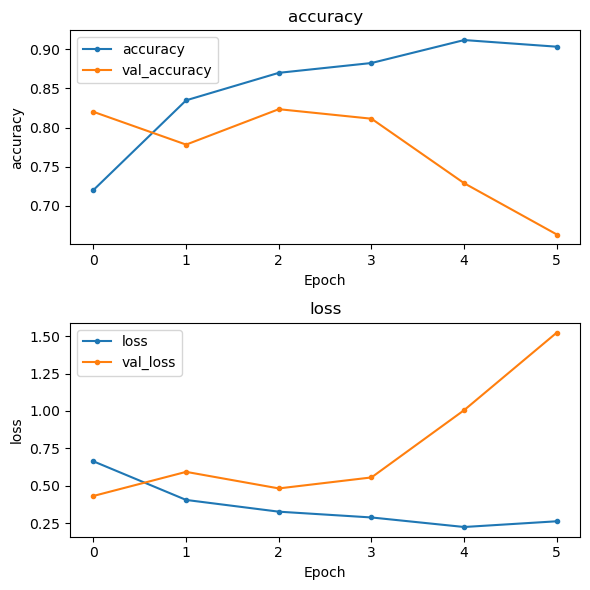


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.70      0.82      1721
           1       0.61      1.00      0.76      1732
           2       1.00      0.65      0.79      1725

    accuracy                           0.78      5178
   macro avg       0.87      0.78      0.79      5178
weighted avg       0.87      0.78      0.79      5178



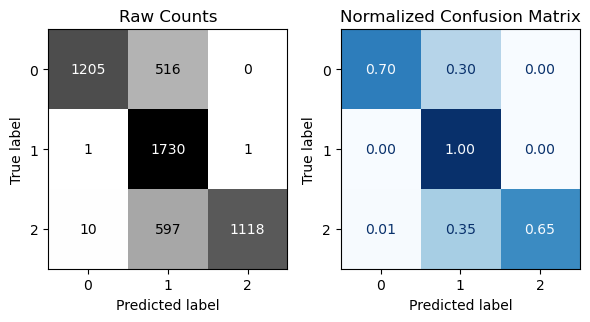


- Evaluating Training Data:
162/162 [==============================] - 87s 536ms/step - loss: 0.6855 - accuracy: 0.7827
{'loss': 0.685455858707428, 'accuracy': 0.7827346324920654}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.52      0.66       253
           1       0.50      0.94      0.65       254
           2       0.97      0.47      0.64       234

    accuracy                           0.65       741
   macro avg       0.79      0.65      0.65       741
weighted avg       0.79      0.65      0.65       741



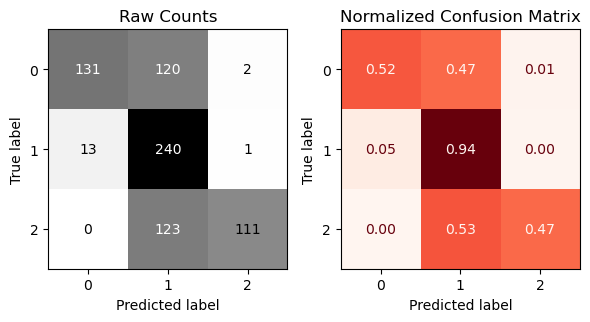


- Evaluating Test Data:
24/24 [==============================] - 13s 528ms/step - loss: 1.7017 - accuracy: 0.6505
{'loss': 1.701697587966919, 'accuracy': 0.6504723429679871}


In [59]:
# Build the model
baseline_model = build_model_glove(sequence_vectorizer,glove_embedding_layer)
EPOCHS = 100
# Fit the mdoel
history = baseline_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)
# Evaluate the mdoel
results = fn.evaluate_classification_network(
    baseline_model, X_train=train_ds, 
    X_test=test_ds, history=history,
);